In [31]:
import tensorflow as tf
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

# Load trained model
MODEL_PATH = "/home/ctp/brain/Brain_segmentation_UNET_RESNET.h5"
model = tf.keras.models.load_model(MODEL_PATH)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 192, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │     27,680 │ re_lu[0][0]       │
│                     │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 128, 128,  │         64 │ input_layer[0][0] │
│                     │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 192, 32)          │            │ conv3d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ add[0][0]         │
│                     │ 192, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling3D)      │ 96, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     55,360 │ max_pooling3d[0]… │
│                     │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 64, 64,    │    110,656 │ re_lu_2[0][0]     │
│                     │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv3d_4[0][0]    │
│ (BatchNormalizatio… │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 64, 64,    │      2,112 │ max_pooling3d[0]… │
│                     │ 96, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 5,692,099 (21.71 MB)

 Trainable params: 5,689,281 (21.70 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 2 (12.00 B)

None


In [32]:
# image preprocessing
nii_img = nib.load('/home/ctp/brain/sub-A00037848_ses-NFB3_T1w.nii.gz')
mri_array = nii_img.get_fdata()

mri_resized = tf.image.resize_with_pad(mri_array, 128, 128).numpy()


# Add a new axis for the channel (grayscale)
mri_resized = mri_resized[..., np.newaxis]

# Expand dimensions to match model input (batch size of 1)
mri_input = np.expand_dims(mri_resized, axis=0)

In [33]:
def visualize_prediction(pred_mask):
    plt.imshow(pred_mask[:, :, pred_mask.shape[2]//2], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


In [ ]:
# scan = nib.load("predicted_mask.nii.gz").get_fdata()
# scan = scan.reshape(1, 128, 128, 192, 1)

In [34]:
pred_mask = model.predict(mri_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [35]:
pred_mask.shape

(1, 128, 128, 192, 1)

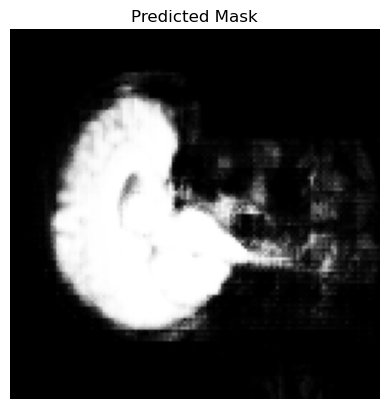

In [36]:

visualize_prediction(pred_mask.reshape(128, 128, 192))